<a href="https://colab.research.google.com/github/kentaNagasawa1996/SPI_Language--NK/blob/master/%E6%84%9F%E6%83%85%E6%A5%B5%E6%80%A7%E5%88%86%E6%9E%90.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
! wget https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv

--2024-03-20 10:19:37--  https://github.com/ids-cv/wrime/raw/master/wrime-ver1.tsv
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv [following]
--2024-03-20 10:19:38--  https://raw.githubusercontent.com/ids-cv/wrime/master/wrime-ver1.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9487235 (9.0M) [text/plain]
Saving to: ‘wrime-ver1.tsv’

wrime-ver1.tsv      100%[===================>]   9.05M  --.-KB/s    in 0.05s   

2024-03-20 10:19:39 (201 MB/s) - ‘wrime-ver1.tsv’ saved [9487235/9487235]



In [2]:
!pip install transformers[torch]
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 290.1/290.1 kB 5.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 47.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 38.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 36.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 1.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 2.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 MB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.1/99.1 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━

In [3]:
import pandas as pd
df_wrime = pd.read_table('wrime-ver1.tsv')
df_wrime.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43200 entries, 0 to 43199
Data columns (total 44 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   Sentence                   43200 non-null  object
 1   UserID                     43200 non-null  int64 
 2   Datetime                   43200 non-null  object
 3   Train/Dev/Test             43200 non-null  object
 4   Writer_Joy                 43200 non-null  int64 
 5   Writer_Sadness             43200 non-null  int64 
 6   Writer_Anticipation        43200 non-null  int64 
 7   Writer_Surprise            43200 non-null  int64 
 8   Writer_Anger               43200 non-null  int64 
 9   Writer_Fear                43200 non-null  int64 
 10  Writer_Disgust             43200 non-null  int64 
 11  Writer_Trust               43200 non-null  int64 
 12  Reader1_Joy                43200 non-null  int64 
 13  Reader1_Sadness            43200 non-null  int64 
 14  Reader

In [4]:
# Plutchikの8つの基本感情
emotion_names = ['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear','Disgust','Trust']

# 客観感情の平均（"Avg. Readers_*"） の値をlist化し、新しい列として定義する
df_wrime['readers_emotion_intensities'] = df_wrime.apply(lambda x: [x['Avg. Readers_' + name] for name in emotion_names], axis=1)

# 感情強度が低いサンプルは除外する
# (readers_emotion_intensities の max が２以上のサンプルのみを対象とする)
is_target = df_wrime['readers_emotion_intensities'].map(lambda x: max(x) >= 2)
df_wrime_target = df_wrime[is_target]

In [5]:
# train / test に分割する
df_groups = df_wrime_target.groupby('Train/Dev/Test')
df_train = df_groups.get_group('train')
df_test = pd.concat([df_groups.get_group('dev'), df_groups.get_group('test')])
print('train :', len(df_train))  # train : 17104
print('test :', len(df_test))    # test : 1133

train : 17104
test : 1133


In [6]:
# HuggingFace Transformers のインストール
# - transformers : 主たるモジュール（モデルやトークナイザ)
# - datasets : HuggingFaceで、データセットを扱うためのモジュール
# cf. https://huggingface.co/docs/transformers/installation
! pip install transformers datasets

# 東北大学の日本語用BERT使用に必要なパッケージをインストール
! pip install fugashi ipadic

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 600.9/600.9 kB 8.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 30.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ipadic: filename=ipadic-1.0.0-py3-none-any.whl size=13556704 sha256=fd53deb8dc1e4de220b3b8f311d9b0330b5392be1277cf888ac64200148b89cc
  Stored in directory: /root/.cache/pip/wheels/5b/ea/e3/2f6e0860a327daba3b030853fce4483ed37468bbf1101c59c3
Successfully built ipadic


In [7]:
from transformers import AutoTokenizer, AutoModelForSequenceClassification

# 使用するモデルを指定して、トークナイザとモデルを読み込む
checkpoint = 'cl-tohoku/bert-base-japanese-whole-word-masking'
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=8)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/120 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/479 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/258k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/445M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at cl-tohoku/bert-base-japanese-whole-word-masking and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from datasets import Dataset
import numpy as np

# 1. Transformers用のデータセット形式に変換
# pandas.DataFrame -> datasets.Dataset
target_columns = ['Sentence', 'readers_emotion_intensities']
train_dataset = Dataset.from_pandas(df_train[target_columns])
test_dataset = Dataset.from_pandas(df_test[target_columns])

# 2. Tokenizerを適用（モデル入力のための前処理）
def tokenize_function(batch):
    """Tokenizerを適用 （感情強度の正規化も同時に実施する）."""
    tokenized_batch = tokenizer(batch['Sentence'], truncation=True, padding='max_length')
    tokenized_batch['labels'] = [x / np.sum(x) for x in batch['readers_emotion_intensities']]  # 総和=1に正規化
    return tokenized_batch

train_tokenized_dataset = train_dataset.map(tokenize_function, batched=True)
test_tokenized_dataset = test_dataset.map(tokenize_function, batched=True)

Parameter 'function'=<function tokenize_function at 0x79e8d19f56c0> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


Map:   0%|          | 0/17104 [00:00<?, ? examples/s]

Map:   0%|          | 0/1133 [00:00<?, ? examples/s]

In [9]:
from transformers import TrainingArguments, Trainer
from datasets import load_metric

# 評価指標を定義
# https://huggingface.co/docs/transformers/training
metric = load_metric("accuracy")
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    label_ids = np.argmax(labels, axis=-1)
    return metric.compute(predictions=predictions, references=label_ids)

# 訓練時の設定
# https://huggingface.co/docs/transformers/v4.21.1/en/main_classes/trainer#transformers.TrainingArguments
training_args = TrainingArguments(
    output_dir="test_trainer",
    per_device_train_batch_size=8,
    num_train_epochs=1.0,
    evaluation_strategy="steps", eval_steps=200)  # 200ステップ毎にテストデータで評価する

# Trainerを生成
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tokenized_dataset,
    eval_dataset=test_tokenized_dataset,
    compute_metrics=compute_metrics,
)

# 訓練を実行
trainer.train()

<ipython-input-9-d0e0229151e4>:6: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss,Validation Loss,Accuracy
200,No log,0.268698,0.585172
400,No log,0.251177,0.631068
600,0.302800,0.236519,0.665490
800,0.302800,0.234113,0.665490
1000,0.259800,0.224069,0.706973
1200,0.259800,0.219624,0.710503
1400,0.259800,0.212420,0.729038
1600,0.249900,0.204646,0.753751
1800,0.249900,0.202770,0.754634
2000,0.238500,0.202478,0.750221


TrainOutput(global_step=2138, training_loss=0.2613687256544522, metrics={'train_runtime': 2050.5511, 'train_samples_per_second': 8.341, 'train_steps_per_second': 1.043, 'total_flos': 4500493926531072.0, 'train_loss': 0.2613687256544522, 'epoch': 1.0})

In [52]:
import pandas as pd
import numpy as np

# ソフトマックス関数
# https://www.delftstack.com/ja/howto/numpy/numpy-softmax/
def np_softmax(x):
    f_x = np.exp(x) / np.sum(np.exp(x))
    return f_x

def analyze_emotion(text, show_fig=False):
    # 推論モードを有効化
    model.eval()

    # 入力データ変換 + 推論
    tokens = tokenizer(text, truncation=True, return_tensors="pt")
    tokens.to(model.device)
    preds = model(**tokens)
    prob = np_softmax(preds.logits.cpu().detach().numpy()[0])

    # textとprobを一つの配列にまとめる
    result = np.array([text] + prob.tolist())
    return result

# ローデータで分析結果を出力

In [64]:
#分析データの読み込み
df = pd.read_csv('test.csv',names=['text'])

# DataFrameから各行の値を取り出してanalyze_emotion関数を実行
results = []
for index, row in df.iterrows():
    result = analyze_emotion(row['text'])
    results.append(result)

# 結果をDataFrameに変換して表示
result_df = pd.DataFrame(results,columns=['text'] + emotion_names)

             text                   Joy                Sadness  \
0      新しいことを始めよう  0.012860703282058239  0.0022245103027671576   
1        明日は海に行こう  0.031875450164079666   0.002882745349779725   
2      今晩は寒くなりそうだ  0.010714076459407806    0.26594096422195435   
3          犬を飼いたい  0.006909914780408144  0.0022702221758663654   
4  今朝のご飯は口に合わなかった  0.020249374210834503     0.8357416391372681   

            Anticipation               Surprise                  Anger  \
0     0.9772337675094604   0.001300601870752871  0.0008228992810472846   
1     0.9563294649124146  0.0018572942353785038  0.0007849809480831027   
2   0.027160724624991417    0.02697237953543663   0.005712381098419428   
3     0.9844774007797241  0.0008323475485667586  0.0007527166744694114   
4  0.0025930856354534626    0.03949049487709999  0.0031479112803936005   

                    Fear                Disgust                  Trust  
0  0.0020538433454930782  0.0016689657932147384   0.001834701281040907  
1  0.0021349

# 感情分類

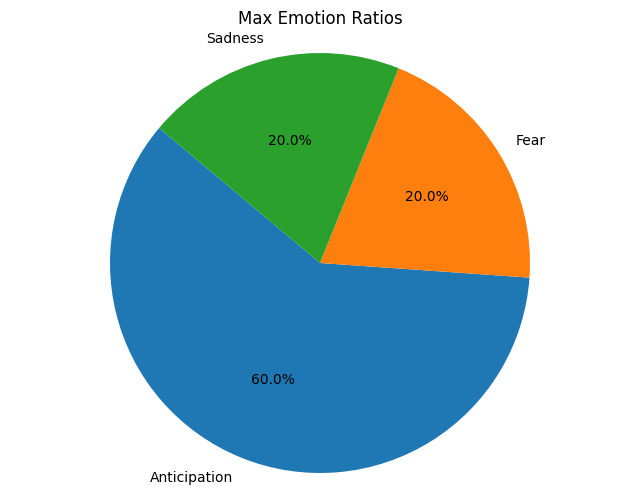

In [73]:
#分析データの読み込み
df = pd.read_csv('test.csv',names=['text'])

# DataFrameから各行の値を取り出してanalyze_emotion関数を実行
results = []
for index, row in df.iterrows():
    result = analyze_emotion(row['text'])
    results.append(result)

# 結果をDataFrameに変換
result_df = pd.DataFrame(results,columns=['text'] + emotion_names)

#result_dfのemotion_names列の値のデータ型を変換
result_df[emotion_names] = result_df[emotion_names].astype(float)

# 各行で最も大きい値を持つ列のカラム名を取得し、列に追加
result_df['max_emotion'] = result_df[['Joy', 'Sadness', 'Anticipation', 'Surprise', 'Anger', 'Fear','Disgust','Trust']].idxmax(axis=1)

# max_emotionの割合を算出
max_emotion_counts = result_df['max_emotion'].value_counts()
max_emotion_ratios = max_emotion_counts / len(result_df)

import matplotlib.pyplot as plt

# max_emotionの割合を円グラフで表示
plt.figure(figsize=(8, 6))
plt.pie(max_emotion_ratios, labels=max_emotion_ratios.index, autopct='%1.1f%%', startangle=140)
plt.title('Max Emotion Ratios')
plt.axis('equal')  # アスペクト比を保持して円を描画する
plt.show()



# 検証用コード

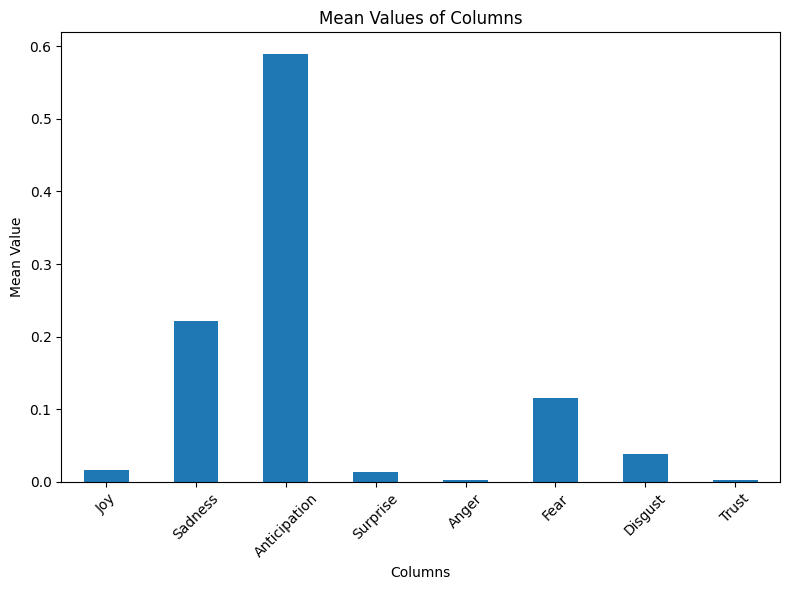

In [81]:
#分析データの読み込み
df = pd.read_csv('test.csv',names=['text'])

# DataFrameから各行の値を取り出してanalyze_emotion関数を実行
results = []
for index, row in df.iterrows():
    result = analyze_emotion(row['text'])
    results.append(result)

# 結果をDataFrameに変換
result_df = pd.DataFrame(results,columns=['text'] + emotion_names)

#result_dfのemotion_names列の値のデータ型を変換
result_df[emotion_names] = result_df[emotion_names].astype(float)

# 列ごとの値の平均を算出
column_means = result_df[emotion_names].mean()

import matplotlib.pyplot as plt

# column_meansを棒グラフで表示
plt.figure(figsize=(8, 6))
column_means.plot(kind='bar')
plt.xlabel('Columns')
plt.ylabel('Mean Value')
plt.title('Mean Values of Columns')
plt.xticks(rotation=45)  # x軸のラベルを45度回転させる
plt.tight_layout()  # グラフのレイアウトを調整
plt.show()